# **Spike Triggered Average – STA**

So far, we have familiarised ourselves with alligning of spike trains to stimulus, binning them and calculating the firing rate. Another interesting analysis we could do with the spike trains from a neuron is calculating the spike triggered average (STA).

STA can be described as a 'memory' of the cell; the relevance of stimuli and the computation a cell can do in time (and space).


**To compute the STA, you will learn to:**

-  Collect the stimulus portions preceding each spike, given a certain time window.
-  Find the average stimulus that evokes spiking.

First, let's import relevant packages:

In [4]:
%matplotlib inline
%config InlineBackend.rc={'figure.figsize': (12, 6), 'font.size': 14 }
from matplotlib import pyplot as plt
import numpy as np
from numpy import load
from pathlib import Path
import math

# **1. The stimulus - Full-field flicker**

The data you are going to work with comes from multielectrode-array recordings of retinal ganglion cells that were stimulated with a full-field flicker stimluli. The full-field flicker consists of a screen-wide presentation of contrast levels that change with a given frequency (here 75Hz). The contrast value of each presentation is calculated from a number that's been taken "randomly" from a Gaussian distribution of mean zero and standard deviation 0.3, with positive values representing brighter, negative values darker presentations.

This is how it would look like:

<img src="images/fff.gif" width="200">


It is assumed that the stimulus presented just before the occurance of a spike is actually what caused it (based on the 'memory' of the cell). Hence, we are going to collect all the contrast values that were presented during a time window preceding **every single spike** and average them. The result of this will be the spike-triggered average, the average stimulus that elicits a spike.

<img src="images/sta.png" width="600">

# **2. Loading the data**

Let us first load the pulses (times of stimulus presentation), the stimulus values.

In [5]:
filepath='data_LN_model/frametimes_fullfieldnoise.txt'
pulses=np.loadtxt(filepath)

## Each pulse marks a change in stimulus presentation

In [6]:
filepath='data_LN_model/stimulus_fullfieldnoise.txt'
stimulus=np.loadtxt(filepath)

## Each value is a contrast value of the screen.

Here, the `stimulus` is organised into **training set** and **test set** during presentation. The **training set** is used for building the model/training the model while the **test set** is used for testing the performance of the model towards predicting responses of the cell.

The training set consists of randomly drawn contrast values from a Gaussian distribution (as mentioned before) and it **does not repeat in trials** whereas the test set is also randomly drawn contrast values but it is the **same in each trial**.

<p><center><img src="images/FFFstimstructure.png" width="600" height="400"></center></p>

The number of frames of training set in each trial is given by `nframes_training=1800` and the number of frames of test set is `nframes_test=600`. Now, our task is to organise the `pulses` and the `stimulus` into trials.

**Exercise:** Reshape the values in `pulses` and `stimulus` into trials.

*Hint:* First make sure that `pulses` and `stimulus` have the same `length`. If not, remove extra elements from `stimulus` from the end.

In [7]:
nframes_training=1800
nframes_test=600

## START CODE HERE ##

# Making sure stimulus and pulses have same length
stimulus=stimulus[:len(pulses)]

# Calculating number of trials and reshaping pulses according to it.
trialframes=nframes_training+nframes_test
num_trials=math.floor(len(pulses)/trialframes)

pulses=pulses[:num_trials*trialframes]
pulses=np.reshape(pulses,(num_trials,trialframes))

stimulus=stimulus[:num_trials*trialframes]
stimulus=np.reshape(stimulus,(num_trials,trialframes))

## END CODE HERE ##

Now let us check if your code is correct.

In [5]:
print(np.shape(pulses))
print(np.shape(stimulus))

(41, 2400)
(41, 2400)


**Expected output:**

`(41, 2400)`
`(41, 2400)`


In [6]:
print(pulses[0,:10])

[1.7499  1.76318 1.77658 1.78986 1.80322 1.81654 1.82986 1.84318 1.85658
 1.8699 ]


**Expected output:** `[1.7499  1.76318 1.77658 1.78986 1.80322 1.81654 1.82986 1.84318 1.85658
 1.8699 ]`


Just as an additional step, let us separate the training set and test set in both `pulses` and `stimulus`. 
This will help us in the future while calculating the STA.

In [8]:
pulses_training=pulses[:,:nframes_training]
pulses_test=pulses[:,nframes_training:]

print(np.shape(pulses_test))
print(np.shape(pulses_training))

stimulus_training=stimulus[:,:nframes_training,]
stimulus_test=stimulus[:,nframes_training:]

(41, 600)
(41, 1800)


# **3. Arranging spike times into trials**

Now that we have organised the `pulses` and `stimulus` into training set and test set, it is time to repeat the process with the spike times. 
Let us load the spike times of one example cell as `spike_times`.

In [9]:
filepath='data_LN_model/fullfieldnoise_C1.txt'
spike_times=np.loadtxt(filepath)

**Exrercise**: Write a function called `get_spikes_training` which takes inputs `spike_times` and `pulses_training` and a second function called `get_spikes_test` with inputs `spike_times` and `pulses_test` to split the values in `spike_times` into `spikes_training` and `spikes_test`.

*Hint:* Use a *for* loop to do it trial-by-trial and by making a list of lists.

In [10]:
def get_spikes_training(spikes, training_pulses):

## START YOUR CODE HERE ##

    numtrials=np.shape(training_pulses)[0]
    spikes_training=[]
    for k in range(numtrials):
        tr=spikes[
            (spikes > training_pulses[k, 0]) & 
            (spikes < training_pulses[k, -1])
        ]
        spikes_training.append(tr)

## END YOUR CODE HERE ##

    return spikes_training

In [11]:
def get_spikes_test(spikes,test_pulses):

## START YOUR CODE HERE ##

    numtrials=np.shape(test_pulses)[0]
    spikes_test=[]
    for k in range(numtrials):
        tr=spikes[
            (spikes > test_pulses[k, 0]) & 
            (spikes < test_pulses[k, -1])
        ]
        spikes_test.append(tr)

## END YOUR CODE HERE ##

    return spikes_test

Now let's check if your fucntions are correct.

In [12]:
spikes_training=get_spikes_training(spike_times, pulses_training)
spikes_training[3][:10] 

array([97.76608, 97.77152, 97.77712, 97.79796, 98.0726 , 98.29824,
       98.34032, 98.34628, 98.36044, 98.37512])

**Expected output:** `array([97.76608, 97.77152, 97.77712, 97.79796, 98.0726 , 98.29824,
       98.34032, 98.34628, 98.36044, 98.37512])`

Similarly for `spikes_test`...

In [13]:
spikes_test=get_spikes_test(spike_times, pulses_test)
spikes_test[5][:10]

array([185.83464, 186.11328, 186.19344, 186.20028, 186.43476, 186.54352,
       186.57872, 186.62796, 186.64208, 186.80132])

**Expected output:** `array([185.83464, 186.11328, 186.19344, 186.20028, 186.43476, 186.54352,
       186.57872, 186.62796, 186.64208, 186.80132])`

**NOTE:** From now on, we will only use `spikes_training` for calculation of **STA**.

# **4. Collecting stimulus before each spike**

As you know by now, the spike-triggered average is calculated by collecting stimulus values before each spike and averaging them. But how long before the spike should we collect the stimulus values ? We have to chose a `time_window` to determine how far in the past we would go to collect the stimulus values.

You can chose anywhere between 500ms to 1000ms. Usually, a `time_window` of 600ms is chosen based on the average activity of the cell.

Let us assume the `time_window` of 600ms or 0.6s.

In [14]:
time_window=0.6

What does this mean in terms of number of `pulses`? We know that the stimulus was presnted at a frequency of 75Hz and each prsentation was marked by a `pulse`. We now have to calculate the `durations` of each pulse and number of pulses in a `time_window`.

Let us now convert our `time_window` from milliseconds or seconds to number of elements in `pulses`.

**Exercise**: Calculate `num_past_pulses` based on `time_window`.

*Hint:* First calculate duration between two consequent `pulses`.

In [15]:
## START CODE HERE##

durations=np.mean(np.diff(pulses))
num_past_pulses=round(time_window/durations)

## END CODE HERE ##

print(num_past_pulses)

45


**Expected output:** `45`

This means that we will have to go `45` frames/values back in time for each spike. However, for the very first spike, probably occuring in the first pulse duration itself, there are no stimulus values back in time. Similarly for all spikes occuring within the first few pulses, there are not enough stimulus values back in time for consideration.

Thus, we will have to **ignore the first few spikes** for the calculation of STA. More specificially, we will have to **ignore all spikes occurring before first `num_past_pulses` pulses**.

This has to be done for spikes in each trial !! 

In [16]:
def get_spikes_STA(training_spikes, training_pulses, num_pastpulses):
    
    spikes_STA=[]

    for k in range(num_trials):
        X=training_spikes[k]
        newset=X [ X > training_pulses[k,num_pastpulses] ]
        spikes_STA.append(newset)
        
    return spikes_STA

In [17]:
spikes_STA=get_spikes_STA(spikes_training,pulses_training,num_past_pulses)

# **5. Calculating the STA**

Finally, we are ready to calculate the spike-triggered average!! Yohoo!!

We have our `pulses_training`, `stimulus_training` and `spikes_STA` ready.

What we now need to do:

1. Select each spike in `spikes_STA`.


2. Check in which `pulses_training` does it occur and note the index of the element.


3. Index the `stimulus_training`from the previously obtained index of `pulses_training` as they have same dimentions.


4. Count `num_past_pulses` values back in time from the index of `stimulus_training`. You will then obtain an array ` 
STA_raw` of size `(1,45)`. 


5. Repeat the process for all spikes, average the `STA_raw` over number of spikes.

Of course, many of these steps can be combined during programming. 😊

**Exercise (hard)**: Fill in the function below to calculate the STA given the imputs `spikes_STA`, `stimulus_training`, `pulses_training` and `num_past_pulses`.

In [20]:
def calculate_STA(spikes_STA, pulses_training, stimulus_training, num_past_pulses):

    ## Flattening the pulses and stimulus for easier indexing
    STApulses=pulses_training.flatten(order='C')

    ## Do the same for stimulus as well
    STAstimulus=stimulus_training.flatten(order='C')

    ## Starting a counter to keep track of iterations
    counter=0
    stim_vector=np.zeros((num_past_pulses, ))

    ## Main loop for STA calculation

    for i in range(num_trials):
        currentspikes=spikes_STA[i]
        counter += len(currentspikes)
        
        for spike in currentspikes:
            stim_window=np.where(STApulses <= spike)[0][-num_past_pulses:] # indexing all 45 frames together
            stim_vector += STAstimulus[stim_window]

    STA=stim_vector/counter
    
    return STA

Now let's see if our function worked by plotting the STA.

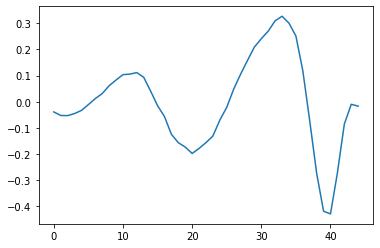

In [22]:
STA=calculate_STA(spikes_STA,pulses_training,stimulus_training,num_past_pulses)
plt.plot(STA)

What do you see? Do you understand the plot?

Let us plot it more accurately here.

In [ ]:
###START CODE HERE###- SHASH PLEASE DO THIS PART

"""
for adequate plotting, create a vector with values within the range of
what is going to be the X-axis and plot the STA against it.

"""

past_time_limit = -avg_diff*window
x_ax = np.linspace(past_time_limit, 0, num=len(sta))
plt.plot(x_ax, sta)

###END CODE HERE

The STA is showing us what stimulus the cell "prefers" in the temporal domain. Depending on the data set you have, it might be that the cells prefers decrease and then increase in contrast before spiking; increase and then decrease in contrast; or just increase in contrast. 

# **6. Normalising the STA**

You may notice that the STA is now in simulus space. i.e each value in STA is an average stimulus value. It is fine to keep it this way for comapring STAs amongst cells. However, if we want to use STAs for moedlling in the LN-model, we need to normalise it to remove biases from firing rate of each cell. This way, the STAs would be normalised/scaled to unit form and readily useable for the next step in the modelling.

For this, we use **euclidean normalisation** as the shape of the STA (direction of vector) matters more than the amplitude of it (magnitude of vector).

The equation for eucledian normalisation is given by:

$$
{x_{norm}} =\frac{x_{i}}{\sqrt{\sum_{i=1}^{N}{x_{i}}^2}}
$$

where $x_i$ is an element in the STA and $N$ is total number of elements. 



**Exercise:** Write a function called `normalise_STA` which takes the STA as input and normalises it using euclidean normalisation.

In [24]:
def normalise_STA (STA_raw):
    
    ## START YOUR CODE HERE ##
    
    STA_norm=STA_raw/ math.sqrt(np.sum(STA_raw**2))  #can use'/' here instead of np.divide() as STA_raw is an np.array
    
    ## END YOUR CODE HERE ##
    
    return STA_norm

# **7. Comparing multiple cells**

So far, we calculated the STA of one example cell. Different cells can have very diverse STAs. The shape of the STA usually depends on the cell-type specification of the neuron (ON-cell, OFF-cell etc.).

Let us look at a few more cells and compare their STAs. For this, we will have to repeat the above steps for each cell.

We already have `pulses_training` and ` stimulus_training`. We now need to load spike times from all cells repeat the steps above.

**Exercise:** Fill the code below with the correct variables and functions to obtain STA for multiple cells.

In [27]:
#This will store the STAs for all cells
multiSTA=[]

# Generate a list of the spike files of all cells
filepaths = sorted(Path('data_LN_model').glob('fullfieldnoise*.txt'))

#Iterate over all files
for filepath in filepaths:
    
    # 1. Load spike times from file
    spike_times = np.loadtxt(filepath)

    # 2. Split the spike times into test set and training set
    spikes_training=get_spikes_training(spike_times,pulses_training)
    
    # 3. Ignore spikes which do not have corresponding stimulus values in the past
    spikes_STA=get_spikes_STA(spikes_training,pulses_training,num_past_pulses)
    
    # 4. Calculate the STA
    STA=calculate_STA(spikes_STA, pulses_training, stimulus_training, num_past_pulses)
    
    # 5. Normalise the STA using euclidean normalisation
    final_STA=normalise_STA(STA)
    
    # 6. Append it to the list of STAs for multiple cells
    multiSTA.append(final_STA)
    
multiSTA=np.array(multiSTA) # To make it easier for plotting

Let's check if your code is correct.

In [50]:
print(np.shape(multiSTA))
print(multiSTA[2,:10])

(8, 45)
[0.04619592 0.04298558 0.02613613 0.03903669 0.03489258 0.02845812
 0.02332268 0.01184162 0.02100312 0.0091886 ]


**Expected output:** ```(8, 45)```
```[0.04619592 0.04298558 0.02613613 0.03903669 0.03489258 0.02845812
 0.02332268 0.01184162 0.02100312 0.0091886 ] ```

Now let us plot STAs from all the cells.

In [ ]:
### SHASH PLEASE FILL THIS ###